In [1]:
!pip freeze > requirements.txt

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import models, transforms
from torchvision.models.vgg import VGG19_Weights

import os
import glob
import tarfile
from PIL import Image
from tqdm import tqdm

In [ ]:
torchvision.datasets.utils.download_url('https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz',os.getcwd())

  0%|          | 0/99003388 [00:00<?, ?it/s]

In [ ]:
with tarfile.open('/content/imagenette2-160.tgz', 'r:gz') as tar:
    tar.extractall(path = '/content/data/')

In [ ]:
def make_file_list(phase = 'train'):
    dir = '/content/data/imagenette2-160/'
    phase = phase
    file_path = os.path.join(dir+phase+'/**/*.JPEG')

    return  list(glob.glob(file_path))

In [ ]:
train_file_list = make_file_list(phase ='train')
val_file_list = make_file_list(phase = 'val')

In [ ]:
class ImageTransforms():
    def __init__(self,resize,mean, std):
        self.data_transforms = {
            'train': transforms.Compose([
            transforms.RandomResizedCrop(resize, scale = (0.5,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(0.25),
            transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(), 
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        }
    def __call__(self, img,phase='train'):
        return self.data_transforms[phase](img)

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, path, transforms = None, phase = 'train'):
        self.path = path
        self.transforms = transforms
        self.phase = phase
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
            
            img = Image.open(self.path[index]).convert('RGB')
            tf_img = self.transforms(img,self.phase)
            if self.phase == 'train':
                if self.path[index][36:45] == 'n03425413':
                    label = 1
                else : 
                    label = 0
            if self.phase == 'val':
                if self.path[index][34:43] == 'n03425413':
                    label = 1
                else : 
                    label = 0

            return tf_img, label

In [ ]:
# val_file_list[0][34:43]
# train_dataset.__getitem__(1)

In [ ]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = Dataset(
    train_file_list, transforms = ImageTransforms(resize,mean, std), phase='train')

val_dataset = Dataset(
    val_file_list, transforms = ImageTransforms(resize,mean, std), phase='val')

In [ ]:
batch_size = 64
train_dataloader = data.DataLoader(
    train_dataset, batch_size= batch_size, shuffle = True, num_workers=4, pin_memory=False)
val_dataloader = data.DataLoader(
    val_dataset, batch_size= batch_size, shuffle = False,num_workers=4, pin_memory=True)
dataloader_dict = {'train' : train_dataloader,
                   'val': val_dataloader}

In [ ]:
print(train_dataloader.batch_sampler)

In [ ]:
model = models.vgg19(weights= VGG19_Weights.IMAGENET1K_V1)

for name, param in model.named_parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features= 4096, out_features = 2)
update_params1 = []
update_params2 = []
update_params3 = []
for name, param in model.named_parameters():
    # print(name)
    if "features" in name:
        update_params1.append(param)
    elif  'classifier.6.' in name:
        update_params3.append(param)
    elif 'classifier' in name:
        update_params2.append(param)

In [ ]:
print(*map(len,[update_params1, update_params2, update_params3] ))

32 4 2


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([{'params': update_params1, 'lr': 1e-4},
                               {'params': update_params2, 'lr': 5e-4},
                               {'params': update_params3, 'lr': 1e-3},])

In [ ]:
def train_model(dataloader_dict, model, criterion, optimizer, num_epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs} ')
        print('-------------------------------')

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            elif phase == 'val':
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            if epoch == 0 and phase == 'train':
                continue

            for inputs, labels in tqdm(dataloader_dict[phase]):

                inputs = inputs.to(device) 
                labels = labels.to(device) 
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, pred = torch.max(outputs,1 )
                                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(pred == labels.data)
    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects / len(dataloader_dict[phase].dataset)
            
            print(f'{phase}, {epoch_loss}, {epoch_acc}')    


In [ ]:
device = torch.device('cuda')
type(device)

torch.device

In [ ]:
num_epochs = 2
train_model(dataloader_dict, model, criterion, optimizer, num_epochs)

Epoch 0 / 2 
-------------------------------


  0%|          | 0/62 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
save_path = './drive/MyDrive/pytorch-deeplearning/weights_fine_tuning.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
load_path = save_path
load_weights = torch.load(load_path, map_location = {'cuda' : 'cpu'})
model.load_state_dict(load_weights)

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size = (2, 3,448,448))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl, mean,std):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, mean,std)
        # ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(denorm_images[0])
        ax.imshow(torchvision.utils.make_grid([denorm_images[0],denorm_images[0].clamp(0,1)] , nrow=2).permute(1, 2, 0))
        # ax.imshow(torchvision.utils.make_grid(denorm_images[:32], nrow=4).permute(1, 2, 0))
        # ax.imshow(torchvision.utils.make_grid(denorm_images[32:], nrow=4))
        break
    print(denorm_images[0])

tensor([[[0.4902, 0.4902, 0.4863,  ..., 0.4039, 0.3922, 0.3843],
         [0.4941, 0.4902, 0.4824,  ..., 0.4078, 0.3922, 0.3843],
         [0.5020, 0.4941, 0.4824,  ..., 0.4118, 0.3961, 0.3882],
         ...,
         [0.5569, 0.5569, 0.5569,  ..., 0.6588, 0.6588, 0.6588],
         [0.5608, 0.5608, 0.5569,  ..., 0.6588, 0.6627, 0.6627],
         [0.5608, 0.5608, 0.5569,  ..., 0.6588, 0.6627, 0.6667]],

        [[0.5176, 0.5176, 0.5137,  ..., 0.3922, 0.3843, 0.3804],
         [0.5216, 0.5176, 0.5098,  ..., 0.3961, 0.3843, 0.3804],
         [0.5216, 0.5176, 0.5059,  ..., 0.3961, 0.3882, 0.3843],
         ...,
         [0.5451, 0.5451, 0.5451,  ..., 0.6627, 0.6627, 0.6627],
         [0.5490, 0.5490, 0.5451,  ..., 0.6627, 0.6667, 0.6667],
         [0.5451, 0.5451, 0.5451,  ..., 0.6627, 0.6667, 0.6706]],

        [[0.3333, 0.3333, 0.3333,  ..., 0.2314, 0.2314, 0.2314],
         [0.3373, 0.3333, 0.3333,  ..., 0.2314, 0.2314, 0.2314],
         [0.3490, 0.3412, 0.3333,  ..., 0.2353, 0.2353, 0.

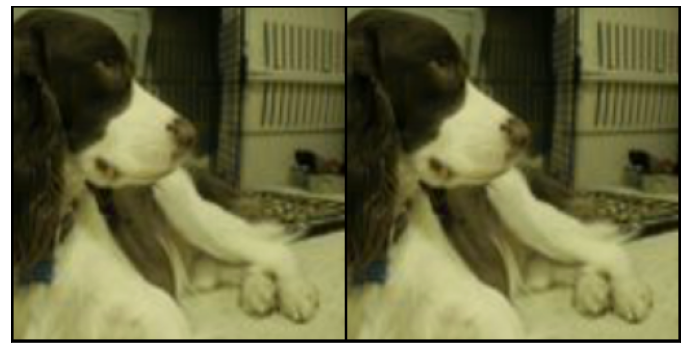

In [ ]:
show_batch(train_dataloader, mean, std)